# Predicting Sunspots Activity with Tensorflow
> "This is a modified version of Laurence Moroney's notebook on predicting Sunspot Activity using Tensorflow with my notes"
- toc: false
- branch: master
- badges: true
- comments: false
- categories: [machinelearning,visualization]

## Downloading the Sunspots Data

The sunspots csv file is hosted on **Laurence Moroney's** blog and we can read it directly into pandas using
`pd.read_csv('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv')`. However, to avoid issues with this url changing in the future we will download and store a copy of the file then read it.

In [26]:
import pandas as pd

sunspots = pd.read_csv('data/Sunspots.csv')
sunspots.columns = ['Index','Date', 'Sunspots']
sunspots.Date = pd.to_datetime(sunspots.Date)
sunspots = sunspots.set_index('Date').drop(columns='Index')

In [27]:
sunspots

,Sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2018-03-31,2.5
2018-04-30,8.9
2018-05-31,13.2


There are over 3200 rows in the dataset representing mean monthly sunspot activity since 1749. 

## Chart of Sunspot Activity

### Tip 1: Change the Matplotlib style
When plotting using **matplotlib** you can improve the look of your charts by switching from the default style. Matplotlib has a `style` package that contains several alternative styles which you can select from using `style.use`.

For our plots we will switch to the `fivethirtyeight` style which mimics the look of the charts used on the data site **fivethirtyeight.com**

In [12]:
import matplotlib.style as style

style.use('fivethirtyeight')

Use `style.available` to view the list of available styles

### Tip 2: Disable cell output
To disable cell output from a code cell in Jupyter notebook add a semi-colon to the end of the last line of code. We do this here to stop Jupyter from displaying the matplotlib the plot object as a string e.g. *'<matplotlib.axes._subplots.AxesSubplot at 0x1f7c683b2c8>'*

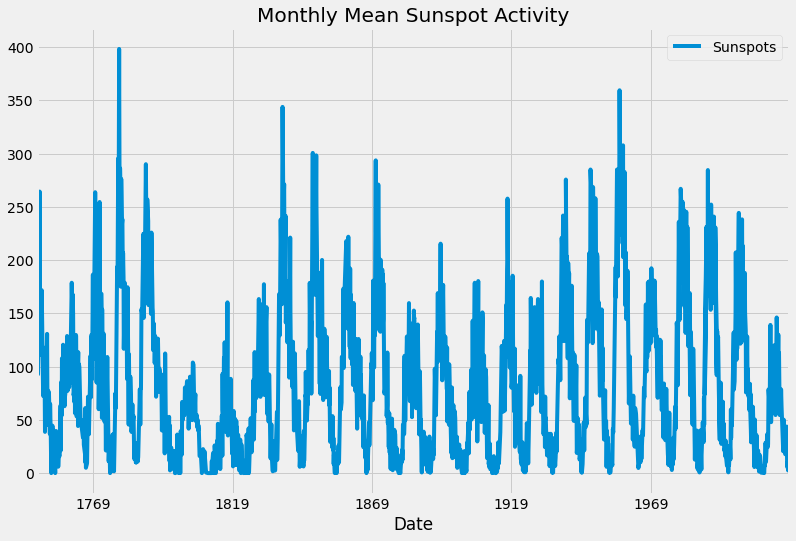

In [8]:
sunspots.plot(figsize=(12,8), title='Monthly Mean Sunspot Activity');

## Split the Dataset into Training and Validation Data
Time series data is normally split into training and validation data at a specific time point. For the sunspot data this will be after 3000 observations, or January 1999. The training data will be data before and vaidation data after.

In [35]:
split_time = 3000
sunspots_train = sunspots.iloc[:split_time]
sunspots_valid = sunspots.iloc[split_time:]

time_train = sunspots_train.index
x_train = sunspots_train.Sunspots

time_valid = sunspots_valid.index
x_valid = sunspots_valid.Sunspots

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

### Training Data

In [36]:
x_train.to_frame()

,Sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
1998-08-31,121.1
1998-09-30,132.0
1998-10-31,78.5


### Validation Data

In [37]:
x_valid.to_frame()

,Sunspots
Date,
1999-01-31,86.0
1999-02-28,98.0
1999-03-31,103.5
1999-04-30,93.6
1999-05-31,149.6
...,...
2018-03-31,2.5
2018-04-30,8.9
2018-05-31,13.2


## Windowed Dataset

This function creates a windowed dataset from a series.

In [83]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

The windowed_dataset function uses some of tensorflow functions

#### tf.data.Dataset.from_tensor_slices(tensors)
*Creates a `Dataset` whose elements are slices of the given tensors.*

The given tensors are sliced along their first dimension. This operation preserves the structure of the input tensors, removing the first dimension of each tensor and using it as the dataset dimension. All input tensors must have the same size in their first dimensions.

```
# Slicing a 1D tensor produces scalar tensor elements.
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
list(dataset.as_numpy_iterator())
>>> [1, 2, 3]
```
```
# Slicing a 2D tensor produces 1D tensor elements.
dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
list(dataset.as_numpy_iterator())
>>> [array([1, 2], dtype=int32), array([3, 4], dtype=int32)]
```

```
# Slicing a tuple of 1D tensors produces tuple elements containing scalar tensors.
dataset = tf.data.Dataset.from_tensor_slices(([1, 2], [3, 4], [5, 6]))
list(dataset.as_numpy_iterator())
>>> [(1, 3, 5), (2, 4, 6)]
```

#### tf.data.Dataset.window(self,size,shift=None,stride=1,drop_remainder=False)
*Combines (nests of) input elements into a dataset of (nests of) windows*
Combines (nests of) input elements into a dataset of (nests of) windows.

A "window" is a finite dataset of flat elements of size `size` (or possibly
fewer if there are not enough input elements to fill the window and
`drop_remainder` evaluates to `False`).

The `shift` argument determines the number of input elements by which the
window moves on each iteration.  If windows and elements are both numbered
starting at 0, the first element in window `k` will be element `k * shift`
of the input dataset. In particular, the first element of the first window
will always be the first element of the input dataset.

The `stride` argument determines the stride of the input elements, and the
`shift` argument determines the shift of the window.

```
Args:
  size: A `tf.int64` scalar `tf.Tensor`, representing the number of elements
    of the input dataset to combine into a window. Must be positive.
  shift: (Optional.) A `tf.int64` scalar `tf.Tensor`, representing the
    number of input elements by which the window moves in each iteration.
    Defaults to `size`. Must be positive.
  stride: (Optional.) A `tf.int64` scalar `tf.Tensor`, representing the
    stride of the input elements in the sliding window. Must be positive.
    The default value of 1 means "retain every input element".
  drop_remainder: (Optional.) A `tf.bool` scalar `tf.Tensor`, representing
    whether the last window should be dropped if its size is smaller than
    `size`.
```

### Creating the windowed dataset

In [41]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


## Creating the RNN Model RNN

The `batch_size` is **64** and the `window_size` is **60**

Then there is a `Conv1D` layer that will learn **32** filters

This will output to a couple of `LSTMs` wth **32** cells each

These feed into a **DNN** consisting of 3 `Dense` layers, **30** neurons then **10**, then **1**

Finally, as the numbers are in the **1-400** range, there is a lambda layer that multiplies by **400**

In [88]:
def create_model():

    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
    ])
    return model

model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense_6 (Dense)              (None, None, 30)          1950      
_________________________________________________________________
dense_7 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_8 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 1)          

### Train for 100 epochs to find the best learning rate

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

### Plot the History of the Loss

(1e-08, 0.0001, 0.0, 60.0)

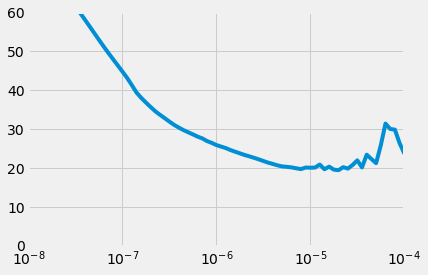

In [44]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

## Train the Model for 500 epochs

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, 
                             window_size=60,
                             batch_size=100, 
                             shuffle_buffer=shuffle_buffer_size)

### Training the model

In [84]:
model = create_model()
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 2s 65ms/step - loss: 14.4280 - mae: 14.9135
Epoch 2/500
30/30 [==============================] - 2s 78ms/step - loss: 14.4937 - mae: 14.9790
Epoch 3/500
30/30 [==============================] - 2s 77ms/step - loss: 14.4400 - mae: 14.9255: 1s - l
Epoch 4/500
30/30 [==============================] - 2s 80ms/step - loss: 14.4315 - mae: 14.9168
Epoch 5/500
30/30 [==============================] - 2s 75ms/step - loss: 15.1452 - mae: 15.6322
Epoch 6/500
30/30 [==============================] - 2s 71ms/step - loss: 14.5989 - mae: 15.0852
Epoch 7/500
30/30 [==============================] - 2s 76ms/step - loss: 14.5703 - mae: 15.0566
Epoch 8/500
30/30 [==============================] - 2s 77ms/step - loss: 14.5151 - mae: 15.0010
Epoch 9/500
30/30 [==============================] - 2s 70ms/step - loss: 14.4061 - mae: 14.8915
Epoch 10/500
30/30 [==============================] - 2s 80ms/step - loss: 14.3626 - mae: 14.8479
Epoch 11/500
30/30 [=

30/30 [==============================] - 2s 77ms/step - loss: 14.1202 - mae: 14.6053
Epoch 85/500
30/30 [==============================] - 2s 78ms/step - loss: 14.0999 - mae: 14.5848
Epoch 86/500
30/30 [==============================] - 2s 77ms/step - loss: 14.3796 - mae: 14.8656
Epoch 87/500
30/30 [==============================] - 2s 77ms/step - loss: 14.3468 - mae: 14.8327
Epoch 88/500
30/30 [==============================] - 2s 79ms/step - loss: 14.1820 - mae: 14.6673
Epoch 89/500
30/30 [==============================] - 2s 79ms/step - loss: 14.0504 - mae: 14.5355
Epoch 90/500
30/30 [==============================] - 2s 77ms/step - loss: 14.2200 - mae: 14.7056
Epoch 91/500
30/30 [==============================] - 2s 75ms/step - loss: 14.0968 - mae: 14.5819
Epoch 92/500
30/30 [==============================] - 2s 79ms/step - loss: 14.2340 - mae: 14.7196
Epoch 93/500
30/30 [==============================] - 2s 80ms/step - loss: 14.0561 - mae: 14.5410
Epoch 94/500
30/30 [=============

30/30 [==============================] - 2s 63ms/step - loss: 13.7257 - mae: 14.2099
Epoch 167/500
30/30 [==============================] - 2s 66ms/step - loss: 13.7018 - mae: 14.1864
Epoch 168/500
30/30 [==============================] - 2s 67ms/step - loss: 13.8466 - mae: 14.3315
Epoch 169/500
30/30 [==============================] - 2s 67ms/step - loss: 13.8022 - mae: 14.2867
Epoch 170/500
30/30 [==============================] - 2s 66ms/step - loss: 13.6922 - mae: 14.1763
Epoch 171/500
30/30 [==============================] - 2s 66ms/step - loss: 13.8684 - mae: 14.3533
Epoch 172/500
30/30 [==============================] - 2s 58ms/step - loss: 13.7327 - mae: 14.2168
Epoch 173/500
30/30 [==============================] - 2s 67ms/step - loss: 14.2046 - mae: 14.6902
Epoch 174/500
30/30 [==============================] - 2s 60ms/step - loss: 13.9645 - mae: 14.4498
Epoch 175/500
30/30 [==============================] - 2s 67ms/step - loss: 13.9924 - mae: 14.4776
Epoch 176/500
30/30 [===

30/30 [==============================] - 2s 66ms/step - loss: 13.5693 - mae: 14.0533
Epoch 249/500
30/30 [==============================] - 2s 66ms/step - loss: 13.8088 - mae: 14.2933
Epoch 250/500
30/30 [==============================] - 2s 63ms/step - loss: 13.3303 - mae: 13.8140
Epoch 251/500
30/30 [==============================] - 2s 65ms/step - loss: 13.5733 - mae: 14.0579
Epoch 252/500
30/30 [==============================] - 2s 66ms/step - loss: 13.4145 - mae: 13.8988
Epoch 253/500
30/30 [==============================] - 2s 66ms/step - loss: 13.2512 - mae: 13.7349
Epoch 254/500
30/30 [==============================] - 2s 64ms/step - loss: 13.5246 - mae: 14.0085
Epoch 255/500
30/30 [==============================] - 2s 64ms/step - loss: 13.6034 - mae: 14.0879
Epoch 256/500
30/30 [==============================] - 2s 66ms/step - loss: 13.4415 - mae: 13.9260
Epoch 257/500
30/30 [==============================] - 2s 59ms/step - loss: 13.2289 - mae: 13.7126
Epoch 258/500
30/30 [===

30/30 [==============================] - 2s 62ms/step - loss: 12.8784 - mae: 13.3616
Epoch 331/500
30/30 [==============================] - 2s 69ms/step - loss: 12.9725 - mae: 13.4557
Epoch 332/500
30/30 [==============================] - 2s 65ms/step - loss: 13.2016 - mae: 13.6851
Epoch 333/500
30/30 [==============================] - 2s 67ms/step - loss: 13.0942 - mae: 13.5780
Epoch 334/500
30/30 [==============================] - 2s 67ms/step - loss: 13.4033 - mae: 13.8883
Epoch 335/500
30/30 [==============================] - 2s 66ms/step - loss: 13.1065 - mae: 13.5907
Epoch 336/500
30/30 [==============================] - 2s 67ms/step - loss: 12.9289 - mae: 13.4121
Epoch 337/500
30/30 [==============================] - 2s 66ms/step - loss: 13.5885 - mae: 14.0733
Epoch 338/500
30/30 [==============================] - 2s 65ms/step - loss: 13.0957 - mae: 13.5791
Epoch 339/500
30/30 [==============================] - 2s 66ms/step - loss: 12.9381 - mae: 13.4213
Epoch 340/500
30/30 [===

30/30 [==============================] - 2s 64ms/step - loss: 12.9680 - mae: 13.4511
Epoch 413/500
30/30 [==============================] - 2s 65ms/step - loss: 13.3905 - mae: 13.8751
Epoch 414/500
30/30 [==============================] - 2s 62ms/step - loss: 12.6201 - mae: 13.1035
Epoch 415/500
30/30 [==============================] - 2s 64ms/step - loss: 12.8793 - mae: 13.3626
Epoch 416/500
30/30 [==============================] - 2s 66ms/step - loss: 12.5209 - mae: 13.0031
Epoch 417/500
30/30 [==============================] - 2s 65ms/step - loss: 12.8123 - mae: 13.2959
Epoch 418/500
30/30 [==============================] - 2s 66ms/step - loss: 12.6710 - mae: 13.1537
Epoch 419/500
30/30 [==============================] - 2s 66ms/step - loss: 13.1237 - mae: 13.6072
Epoch 420/500
30/30 [==============================] - 2s 66ms/step - loss: 13.1291 - mae: 13.6128
Epoch 421/500
30/30 [==============================] - 2s 68ms/step - loss: 12.6217 - mae: 13.1042
Epoch 422/500
30/30 [===

30/30 [==============================] - 2s 65ms/step - loss: 12.5801 - mae: 13.0633
Epoch 495/500
30/30 [==============================] - 2s 67ms/step - loss: 12.4631 - mae: 12.9455
Epoch 496/500
30/30 [==============================] - 2s 67ms/step - loss: 12.4712 - mae: 12.9539
Epoch 497/500
30/30 [==============================] - 2s 67ms/step - loss: 12.2175 - mae: 12.6986
Epoch 498/500
30/30 [==============================] - 2s 67ms/step - loss: 12.3686 - mae: 12.8508
Epoch 499/500
30/30 [==============================] - 2s 66ms/step - loss: 12.1985 - mae: 12.6797
Epoch 500/500
30/30 [==============================] - 2s 67ms/step - loss: 12.7745 - mae: 13.2573


## Use the RNN Model to Forecast

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [48]:
rnn_forecast = model_forecast(model, sunspots.Sunspots.values[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

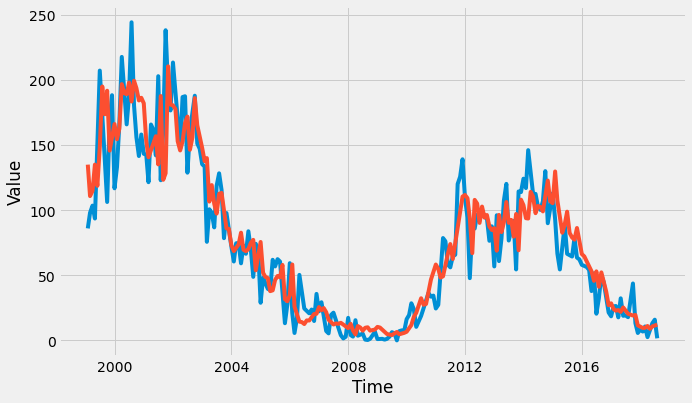

In [49]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [50]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.422706

In [73]:
pd.DataFrame({'Loss':loss})

,Loss
0,38.918026
1,25.765266
2,22.075462
3,20.465935
4,19.714697
...,...
495,14.506039
496,14.555639
497,14.474519
498,14.518973


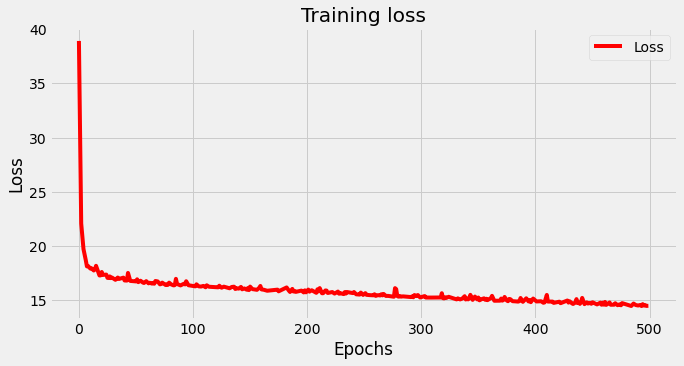

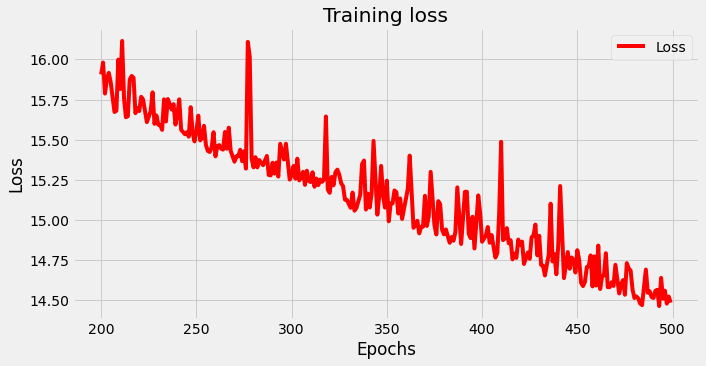

In [70]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs
plt.figure(figsize=(10,5))

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure(figsize=(10,5));



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"]);

#plt.figure(figsize=(10,5));

In [54]:
print(rnn_forecast)

[134.98244   110.82611   114.78729   134.98853   118.712616  148.78526
 195.01509   173.6626    191.73729   145.74232   155.11195   166.1346
 154.48273   162.45761   196.81697   189.9164    189.06967   198.00444
 183.45395   199.4184    193.67168   184.28574   186.33185   182.10037
 153.07948   140.62085   146.7681    154.40736   156.8099    135.1723
 187.67674   123.34991   128.3669    210.49504   181.07677   180.50873
 177.58247   153.00078   145.87062   152.78781   167.03244   171.89093
 146.40634   155.82954   186.05638   165.21962   154.7148    147.80774
 137.6614    139.99048   106.60057   119.253494  104.94592    97.37603
 112.63413   113.26444   101.06034    86.088844   85.60046    73.162056
  68.6046     70.961105   73.70718    82.703766   69.59791    68.522285
  70.1043     74.984116   77.21284    53.84265    63.24909    75.5799
  51.90594    48.781406   47.86377    37.82338    38.431313   46.396378
  49.4634     48.429012   57.966995   31.64944    30.046059   34.583626
  58.